In [198]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
import copy
from collections import Counter

<h2>Game modeling</h2>

In [344]:
possible_states = np.matrix([[0,0,0,0,1,1],
                            [1,0,1,0,1,0],
                            [1,1,1,1,1,0],
                            [0,0,0,0,1,0],
                            [0,0,0,0,1,0]])
def is_valid(a,pos,ori):
    x,y = pos
    if ori==0:
        return (x-1 >= 0) and possible_states[(x-1,y)]
    elif ori==1:
        return (y+1 <= 5) and possible_states[(x,y+1)]
    elif ori==2:
        return (x+1 <= 4) and possible_states[(x+1,y)]
    else:
        return (y-1 >= 0) and possible_states[(x,y-1)]

def take_action(a,pos,ori):
    x,y = pos
    if a==0: #turn
        position = pos
        orientation = (ori + 1) %4
    else: #go forward
        orientation = ori
        if ori==0:
            position = (x-1,y)
        elif ori==1:
            position = (x,y+1)
        elif ori==2:
            position = (x+1,y)
        else:
            position = (x,y-1)
    return position,orientation

bad_states_list = [(1,0),(1,2),(4,4)]
def evaluate_cost(pos):
    if pos in bad_states_list:
        return 0
    if pos==(0,5):
        return 1000
    return 0

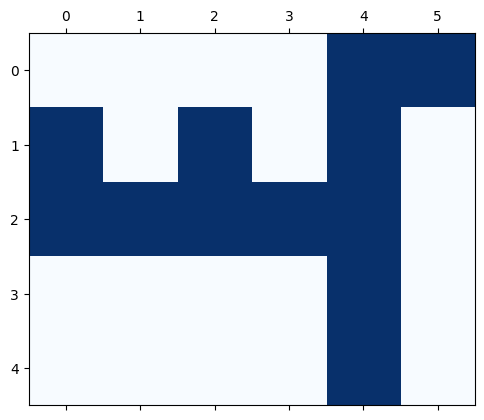

In [49]:
plt.matshow(possible_states, cmap=plt.cm.Blues)

In [343]:
def follow_sequence_actions(sequence,position,orientation):
    cost = 0
    for action in sequence:
        if action==0 or is_valid(action,position,orientation):
            position,orientation = take_action(action,position,orientation)
            cost += evaluate_cost(position)
        else: #invalid action
            return 0
    return cost

In [61]:
sequence_list = []
for b1 in range(2):
    for b2 in range(2):
        for b3 in range(2):
            for b4 in range(2):
                for b5 in range(2):
                    for b6 in range(2):
                        for b7 in range(2):
                            for b8 in range(2):
                                for b9 in range(2):
                                    for b10 in range(2):
                                        sequence_list.append((b1,b2,b3,b4,b5,b6,b7,b8,b9,b10))

In [62]:
def stringify(seq):
    string = ''
    for n in seq:
        string+=str(n)
    return string

In [345]:
position = (2,2)
orientation = 0 #0 North, 1 East, 2 south, 3 West

possible_sequence = []
possible_sequence_cost = []
for sequence in sequence_list:
    cost = follow_sequence_actions(sequence,position,orientation)
    if cost!=None:
        possible_sequence_cost.append(cost)
        possible_sequence.append(sequence)

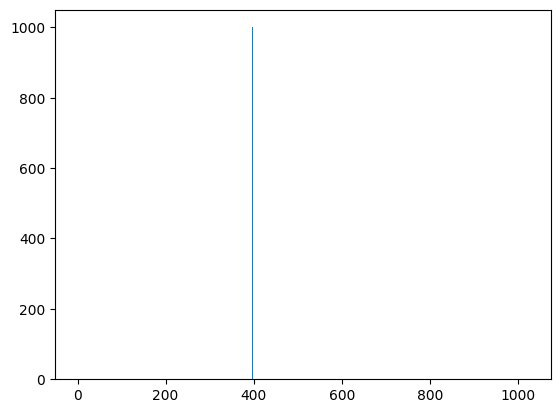

In [346]:
plt.bar([i for i in np.arange(len(possible_sequence))],possible_sequence_cost,width=0.5)
plt.show()

In [347]:
print(np.argmax(possible_sequence_cost))
possible_sequence[np.argmax(possible_sequence_cost)]

397


(0, 1, 1, 0, 0, 0, 1, 1, 0, 1)

<h2>Compressive Sensing</h2>
<h3>Ideal compressive sensing</h3>

In [20]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

In [21]:
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats

In [325]:
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats

In [340]:
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats

In [42]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(i,f)
    return f

c:\Users\Baptiste\Documents\PhD\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


1000.0000000000001


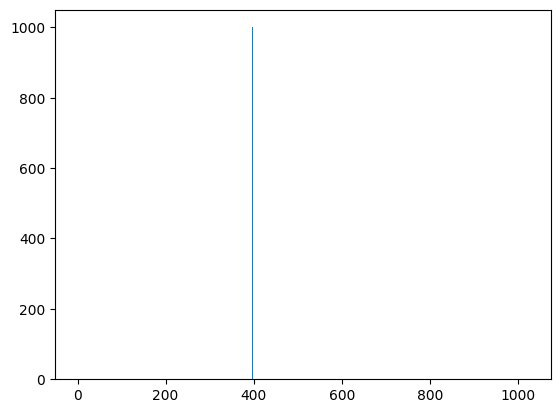

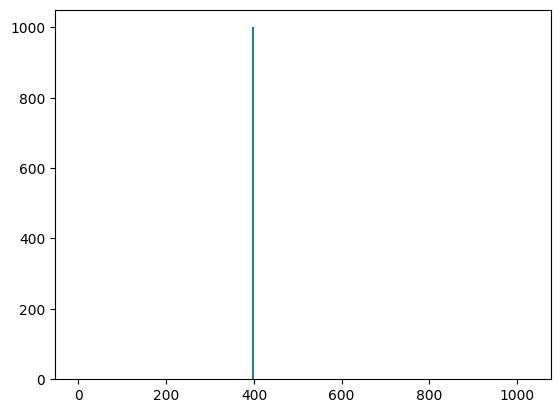

In [348]:
#Nearest neighbor measurements
all_pat = []
y = []

for bit in range(9):
    all_pat +=  create_specific_patterns(bit,bit+1,10)

Phi = np.array([dev_pattern(p) for p in all_pat])
y = np.array(Phi * np.matrix(possible_sequence_cost).T).T[0]

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

print(coefficients[397])

plt.bar([i for i in np.arange(len(possible_sequence))],possible_sequence_cost,width=0.5)
plt.show()
plt.bar([i for i in np.arange(len(coefficients))],coefficients,width=5)
plt.show()

3360


c:\Users\Baptiste\Documents\PhD\.venv\Lib\site-packages\sklearn\utils\_param_validation.py:189: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  return func(*args, **kwargs)


999.9999999999999


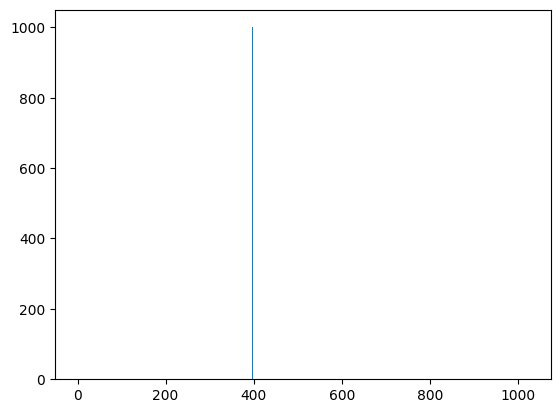

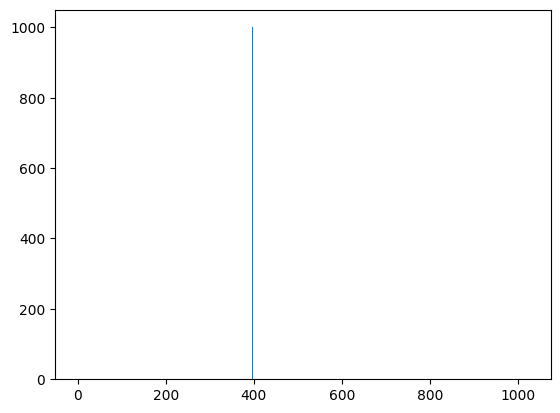

In [349]:
#Triplets measurements
all_pat = []
y = []

all_pat = []
for i in range(10):
    for j in range(i+1,10):
        # all_pat += create_specific_patterns(i,j,10)
        for k in range(j+1,10):
            # all_pat += create_specific_patterns3(i,j,k,10)
            for l in range(k+1,10):
                all_pat += create_specific_patterns4(i,j,k,l,10)

print(len(all_pat))

Phi = np.array([dev_pattern(p) for p in all_pat])
y = np.array(Phi * np.matrix(possible_sequence_cost).T).T[0]

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=30)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

print(coefficients[397])

plt.bar([i for i in np.arange(len(possible_sequence))],possible_sequence_cost,width=0.5)
plt.show()
plt.bar([i for i in np.arange(len(coefficients))],coefficients,width=1)
plt.show()

1906.1389837005943


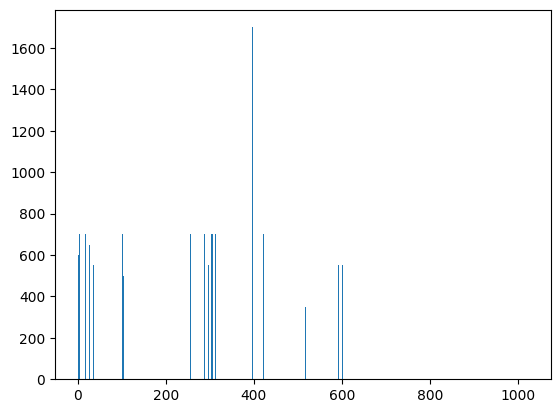

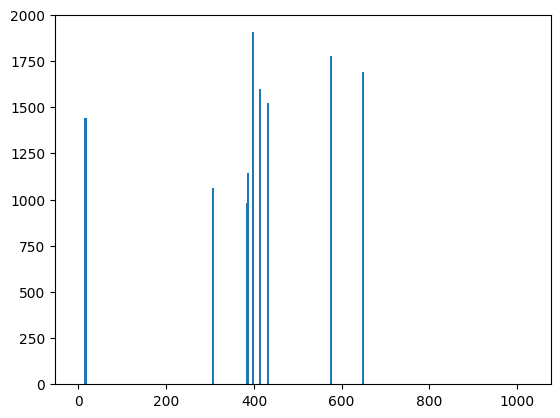

In [323]:
#Random measurements
cheat_Phi = np.random.rand(200,1024)
cheat_y = np.array(cheat_Phi * np.matrix(possible_sequence_cost).T).T[0]

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)
omp.fit(cheat_Phi, cheat_y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

print(coefficients[397])

plt.bar([i for i in np.arange(len(possible_sequence))],possible_sequence_cost,width=0.5)
plt.show()
plt.bar([i for i in np.arange(len(coefficients))],coefficients,width=5)
plt.show()

<h3>Estimated measurement monte carlo</h3>

In [351]:
def estimate_measurement(bit1,bit2,v1,v2):
    costs = []
    for seq,cost in zip(seq_sample,seq_sample_cost):
        if seq[bit1]==v1 and seq[bit2]==v2:
            costs.append(cost)
    if costs == []:
        return
    else:
        return np.sum(costs)

In [363]:
#Sample from possible sequences (be careful not to take the solution already)
seq_sample = []
seq_sample_cost = []
for _ in range(200):
    i = np.random.randint(0,len(possible_sequence))
    seq_sample.append(possible_sequence[i])
    seq_sample_cost.append(possible_sequence_cost[i])

In [364]:
all_pat = []
y = []

for bit in range(9):
    all_pat +=  create_specific_patterns(bit,bit+1,10)
    for v1 in range(2):
        for v2 in range(2):
            # print(v1,v2)
            res = estimate_measurement(bit,bit+1,v1,v2)
            if res!=None:
                y.append(res)

Phi = np.array([dev_pattern(p) for p in all_pat])

y = np.array(y)
y

array([   0, 1000,    0,    0,    0,    0,    0, 1000,    0,    0, 1000,
          0, 1000,    0,    0,    0, 1000,    0,    0,    0,    0, 1000,
          0,    0,    0,    0,    0, 1000,    0,    0, 1000,    0,    0,
       1000,    0,    0])

c:\Users\Baptiste\Documents\PhD\.venv\Lib\site-packages\sklearn\linear_model\_omp.py:445: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


0


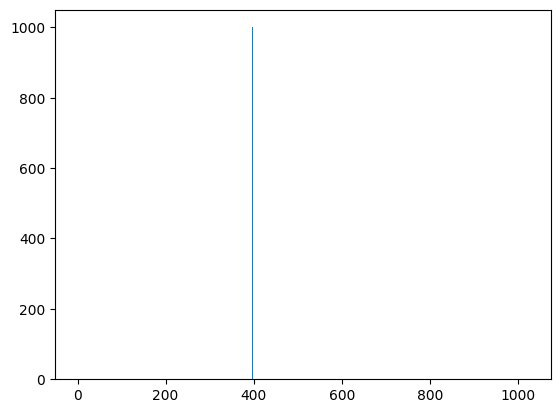

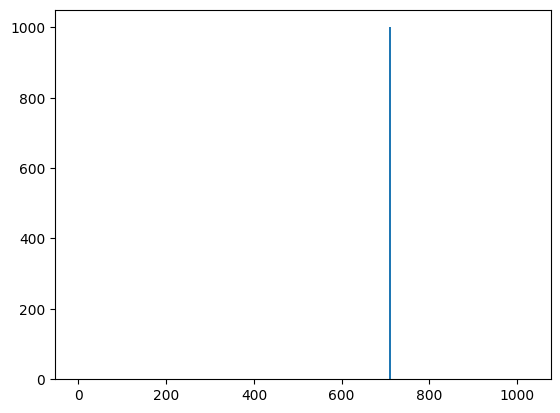

In [365]:
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=20)
omp.fit(Phi, y)
coefficients = [ i if i>0 else 0 for i in omp.coef_]

print(coefficients[397])

plt.bar([i for i in np.arange(len(possible_sequence))],possible_sequence_cost,width=0.5)
plt.show()
plt.bar([i for i in np.arange(len(coefficients))],coefficients,width=5)
plt.show()